In [1]:
import pickle
import torch
import numpy as np
import sbibm
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from pathlib import Path

import lanfactory

# Plotting settings
plt.style.use('../plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Fix seed for figures.
seed = 223174 #torch.randint(1000000, (1,))
torch.manual_seed(seed)
print(f"seed {seed}")

BASE_DIR = Path.cwd().parent.parent.as_posix()
data_folder = BASE_DIR + "/data/"
model_folder = BASE_DIR + "/notebooks/mnle-lan-comparison/models/"
save_folder = BASE_DIR + "/data/results/"

# Set log-likelihood lower bound for all methods, use 1e-7 as the highest bound used during training (e.g., for 10^11 budget LANs).
l_lower_bound = 1e-7
LL_LOWER_BOUND = np.log(l_lower_bound)

seed 223174


In [2]:
# Load pre-simulated training data
with open(data_folder + "ddm_training_and_test_data_10mio.p", "rb") as fh:
    theta, x_1d, xos_1d, thos = pickle.load(fh).values()

num_simulations = 10_000

theta = theta[:num_simulations]

# encode x as (time, choice)
x = torch.zeros((num_simulations, 2))
x[:, 0] = abs(x_1d[:num_simulations, 0])
x[x_1d[:num_simulations, 0] > 0, 1] = 1

# encode xos as (time, choice)
xos = torch.zeros((xos_1d.shape[0], 2))
xos[:, 0] = abs(xos_1d[:, 0])
xos[xos_1d[:, 0] > 0, 1] = 1

## Calculate metrics from pre-trained models

In [4]:
# load one pre-trained model
with open(model_folder + "mnle_n100000_0_0.p", "rb") as fh:
    mnle = pickle.load(fh)

In [5]:
seed = torch.randint(100000, (1,)).item()

task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator(seed=seed) # Passing the seed to Julia.

### Show single likelihood

In [6]:
# Sample one parameter from the prior for a likelihood example.
theta_o = prior.sample((1,))
theta_o

tensor([[-0.4356,  1.7878,  0.5795,  0.5698]])

In [7]:
# RT range
test_tmax = 5
# Number of test points
ntest = 1000
rs = torch.cat((torch.linspace(test_tmax, l_lower_bound, ntest//2), 
           torch.linspace(l_lower_bound, test_tmax, ntest//2))).reshape(-1, 1)
cs = torch.cat((torch.zeros(ntest//2), 
           torch.ones(ntest//2))).reshape(-1, 1)

test_x = torch.hstack((rs, cs))
test_rts = torch.linspace(-test_tmax, test_tmax, ntest)

In [8]:
# get NLE synthetic likelihood for each data point with fixed theta.
lps_mnle = mnle.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()

# from analytical likelihood
lps_true = torch.tensor([task.get_log_likelihood(theta_o, d.reshape(-1, 1), l_lower_bound=l_lower_bound) 
                     for d in test_rts])


/home/janfb/.local/lib/python3.7/site-packages/julia/core.py:691: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


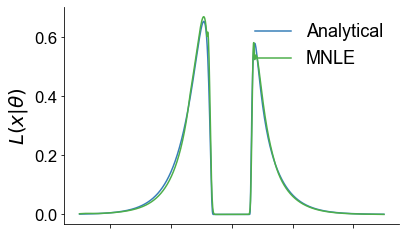

In [9]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Analytical", 
          "MNLE", 
         ]
xticks = np.arange(-4, 5, 2)

plt.plot(test_rts, lps_true.exp(), label="Analytical L", c=colors[0]);
plt.plot(test_rts, lps_mnle.exp(), label="MNLE", ls="-", c=colors[2]);
plt.ylabel(r"$L(x | \theta)$");
plt.legend(labels)
plt.xticks(xticks, []);

### Systematic comparison

In [10]:
# Define losses.
def huber_loss(y, yhat):
    diff = abs(y-yhat)
    
    err = np.zeros(y.numel())
    err[diff <= 1.0] = 0.5 * diff[diff <= 1.0]**2
    err[diff > 1.0] = 0.5 + diff[diff > 1.0]
    return err.mean()

def mean_squared_error(y, yhat):
    return torch.mean((y - yhat)**2)

In [94]:
def score_mnle(path_to_model, num_observations, num_thetas_per_observation):

    # load model
    with open(path_to_model, "rb") as fh:
        mnle, *_ = pickle.load(fh).values()

    errors = []
    for idx in range(num_observations):
        # Sample test thetas from prior.
        test_thetas = thos[idx][:num_thetas_per_observation]
        xoi = xos_1d[idx].reshape(-1, 1)

        # Evaluate
        lps_mnle_i = mnle.log_prob(xos[idx].repeat(num_thetas_per_observation, 1), test_thetas).detach()

        # apply lower bound
        below_bound = lps_mnle_i < LL_LOWER_BOUND
        lps_mnle_i[below_bound] = LL_LOWER_BOUND
        lps_true_i = task.get_log_likelihood(test_thetas, data=xoi.reshape(1, -1), l_lower_bound=np.exp(LL_LOWER_BOUND))

        # Score
        errors.append([
            huber_loss(lps_mnle_i, lps_true_i),
            huber_loss(lps_mnle_i.exp(), lps_true_i.exp()),
            mean_squared_error(lps_mnle_i, lps_true_i),
            mean_squared_error(lps_mnle_i.exp(), lps_true_i.exp()),
            ])

    return np.array(errors)

from torch.distributions.transforms import AffineTransform
# Transform scales param "a" by 0.5
lan_transform = AffineTransform(torch.zeros(1, 4), torch.tensor([[1.0, 0.5, 1.0, 1.0]]))

def lan_likelihood(theta, data, net):
    """Return log likelihood summed over all trials in data, 
        given a batch of parameters theta.
    
    Args
        theta: batch of parameters
        data: batch of iid reaction times and choices encoded
            as negative and positive reaction times. 
        net: lan keras model
        
    Returns
        llsum: batch of log likelihoods over trials. 
    """
    
    # Convert to positive rts.
    rts = abs(data)
    num_trials = rts.numel()
    assert num_trials == 1, "this function assumes single trials."
    num_parameters = theta.shape[0]
    assert rts.shape == torch.Size([num_trials, 1])
    theta = torch.tensor(theta, dtype=torch.float32)
    # Convert DDM boundary seperation to symmetric boundary size.
    theta_lan = theta
    # lan_transform(theta)

    # Code down -1 up +1.
    cs = torch.ones_like(rts)
    cs[data < 0] *= -1

    batch = torch.hstack((theta_lan, rts.repeat(num_parameters, 1), cs.repeat(num_parameters, 1)))

    # Evaluate LAN on batch (as suggested in LANfactory README.)
    logabsdet = lan_transform.log_abs_det_jacobian(theta_lan, theta)
    return net(batch).squeeze() #+ logabsdet.sum(1)

def score_lan(network_file_path, num_observations, num_thetas_per_observation):

    # get network config from model folder.
    with open(list(network_file_path.parent.glob("*_network_config.pickle"))[0], "rb") as fh:
        network_config = pickle.load(fh)

    # load model
    network = lanfactory.trainers.LoadTorchMLPInfer(model_file_path = network_file_path,
                                                network_config = network_config,
                                                input_dim = 6)  # 4 params plus 2 data dims

    errors = []
    for idx in range(num_observations):
        # Sample test thetas from prior.
        test_thetas = thos[idx][:num_thetas_per_observation]
        xoi = xos_1d[idx].reshape(-1, 1)
        
        # Evaluate
        lps_lankde_i = lan_likelihood(test_thetas, xoi, network)
        # apply lower bound
        below_bound = lps_lankde_i < LL_LOWER_BOUND
        lps_lankde_i[below_bound] = LL_LOWER_BOUND
        lps_true_i = task.get_log_likelihood(test_thetas, data=xoi.reshape(1, -1), l_lower_bound=np.exp(LL_LOWER_BOUND))

        # Score
        errors.append([
            huber_loss(lps_lankde_i, lps_true_i),
            huber_loss(lps_lankde_i.exp(), lps_true_i.exp()),
            mean_squared_error(lps_lankde_i, lps_true_i),
            mean_squared_error(lps_lankde_i.exp(), lps_true_i.exp()),
            ])

    return np.array(errors)


### Calculate metrics for every trained model (~5min per budget)

### LAN metrics

In [96]:
num_workers = 1
num_observations = 1000
num_thetas_per_observation = 10000

# set budget for which to calculate
budget = "10_6_ours"
model_folder = Path.cwd() / f"data/torch_models/ddm_{budget}/"  # Pathlib object
model_paths = list(model_folder.glob(f"*_ddm_{budget}_torch_state_dict.pt"))
# model_paths

results = Parallel(n_jobs=num_workers)(
    delayed(score_lan)(model_path, num_observations, num_thetas_per_observation) for model_path in model_paths
)

with open(save_folder + f"lan_likelihood_metrics_n{budget}.p", "wb") as fh:
    pickle.dump(dict(
        results=np.array(results),
        num_observations=num_observations, 
        num_thetas_per_observation=num_thetas_per_observation, 
        model_paths=model_paths), fh)

tanh
linear


/home/janfb/anaconda3/envs/mnle/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### MNLE metrics

In [13]:
num_workers = 1
num_observations = 1000
num_thetas_per_observation = 10000

# set budget for which to calculate
budget = 1000000
model_folder = Path.cwd() / "models"  # Pathlib object
model_paths = list(model_folder.glob(f"*n{budget}_new_*"))
# model_paths

results = Parallel(n_jobs=num_workers)(
    delayed(score_mnle)(model_path, num_observations, num_thetas_per_observation) for model_path in model_paths
)

with open(save_folder + f"mnle_likelihood_metrics_n{budget}.p", "wb") as fh:
    pickle.dump(dict(
        results=np.array(results),
        num_observations=num_observations, 
        num_thetas_per_observation=num_thetas_per_observation, 
        model_paths=model_paths), fh)


In [100]:
with open(save_folder + "mnle_likelihood_metrics_n10000.p", "rb") as fh:
    results_10k, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "mnle_likelihood_metrics_n100000.p", "rb") as fh:
    results_100k, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "mnle_likelihood_metrics_n1000000.p", "rb") as fh:
    results_1000k, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "lan_likelihood_metrics_n10_4.p", "rb") as fh:
    results_10k_lan, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "lan_likelihood_metrics_n10_5.p", "rb") as fh:
    results_100k_lan, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "lan_likelihood_metrics_n10_6.p", "rb") as fh:
    results_1000k_lan, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "lan_likelihood_metrics_n10_8_ours.p", "rb") as fh:
    results_100000k_lan, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "lan_likelihood_metrics_n10_7.p", "rb") as fh:
    results_10000k_lan, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "lan_likelihood_metrics_n10_11.p", "rb") as fh:
    results_10_11_lan, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()


In [101]:
results_1000k_lan.shape

(10, 1000, 4)

In [102]:
metrics = []
metrics_lan = []

for ii in range(4):
    metrics.append(np.vstack((results_10k.mean(1)[:, ii], results_100k.mean(1)[:, ii], results_1000k.mean(1)[:10, ii])).T)
    metrics_lan.append(np.vstack((results_10k_lan.mean(1)[:, ii], results_100k_lan.mean(1)[:, ii], 
        results_1000k_lan.mean(1)[:, ii], # results_10000k_lan.mean(1)[:, ii]
        )).T)

metrics = np.array(metrics)
metrics_lan = np.array(metrics_lan)

In [103]:
metrics.mean(1), metrics_lan.mean(1), metrics.shape

(array([[9.29757440e-01, 3.42089033e-01, 1.36688913e-01],
        [1.60344044e-02, 3.87277068e-03, 1.64021046e-03],
        [5.47505700e+00, 1.69908631e+00, 6.17124857e-01],
        [3.41200810e-02, 7.59002149e-03, 3.18347416e-03]]),
 array([[ 2.27115991,  1.61731971,  1.35277034],
        [ 0.08996776,  0.08361086,  0.08055558],
        [18.83398216, 11.11521409, 10.78480848],
        [ 0.18547468,  0.18369715,  0.16096341]]),
 (4, 10, 3))

### Simple comparison plot

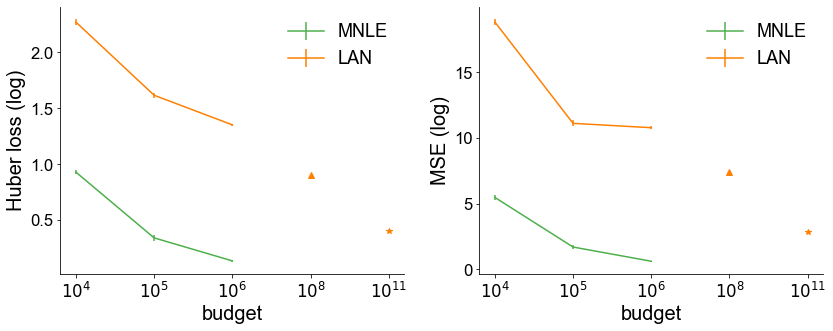

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
# labels = ["Huber loss (log)", "Huber loss", "MSE (log)", "MSE"]
labels = ["Huber loss (log)", "MSE (log)"]
budgets = [r"$10^4$", r"$10^5$", r"$10^6$"]
axidx = 0
for idx, m in enumerate(metrics):
    if idx in [0, 2]:
        plt.sca(ax[axidx])
        plt.errorbar(budgets, m.mean(0), m.std(0)/np.sqrt(m.shape[0]), label="MNLE", color=colors[2])
        plt.errorbar(budgets, metrics_lan[idx].mean(0), metrics_lan[idx].std(0)/np.sqrt(metrics_lan[idx].shape[0]), label="LAN", color=colors[1])
        plt.plot([r"$10^{8}$"], results_100000k_lan.mean(1).mean(0)[idx], color=colors[1], marker="^")
        plt.plot([r"$10^{11}$"], results_10_11_lan.mean(1).mean(0)[idx], color=colors[1], marker="*")
        plt.ylabel(labels[axidx])
        plt.legend()
        plt.xlabel("budget")
        axidx += 1
plt.tight_layout()